# Telco Customer Churn Analysis #

1. Importing all the necessary  python libraries for EDA

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle

2. Data Loading and Understanding

In [7]:
churn_df=pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [8]:
churn_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [9]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [10]:
#dropping customerId as this is not important  in modelling
churn_df=churn_df.drop(columns=['customerID'])

In [11]:
churn_df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [12]:
churn_df.duplicated().sum()

22

In [13]:
num_list=["tenure","MonthlyCharges","TotalCharges"]

for col in churn_df.columns:
    if col not in num_list:
        print(col, churn_df[col].unique())
        print("--"*30)

gender ['Female' 'Male']
------------------------------------------------------------
SeniorCitizen [0 1]
------------------------------------------------------------
Partner ['Yes' 'No']
------------------------------------------------------------
Dependents ['No' 'Yes']
------------------------------------------------------------
PhoneService ['No' 'Yes']
------------------------------------------------------------
MultipleLines ['No phone service' 'No' 'Yes']
------------------------------------------------------------
InternetService ['DSL' 'Fiber optic' 'No']
------------------------------------------------------------
OnlineSecurity ['No' 'Yes' 'No internet service']
------------------------------------------------------------
OnlineBackup ['Yes' 'No' 'No internet service']
------------------------------------------------------------
DeviceProtection ['No' 'Yes' 'No internet service']
------------------------------------------------------------
TechSupport ['No' 'Yes' 'No interne

In [14]:
churn_df["TotalCharges"]=churn_df["TotalCharges"].replace({" ":"0.0"})

In [15]:
churn_df["TotalCharges"]=churn_df["TotalCharges"].astype(float)

In [16]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [17]:
print(churn_df["Churn"].value_counts())

No     5174
Yes    1869
Name: Churn, dtype: int64


In [18]:
churn_df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


Data distribution 

In [19]:
def plot_histogram(df,column_name):
    
    plt.figure(figsize=(5,3))
    sns.histplot(df[column_name],kde=True)
    plt.title(f"Distribution of {column_name}")
    
    #calculate the mean and median values for the columns
    col_mean=df[column_name].mean()
    col_median=df[column_name].median()
    
    #add vertical lines for mean and median
    plt.axvline(col_mean, color="red",linestyle="--" ,label="Mean")
    plt.axvline(col_median, color="green",linestyle="-" ,label="Median")
    
    plt.legend()
    plt.show()

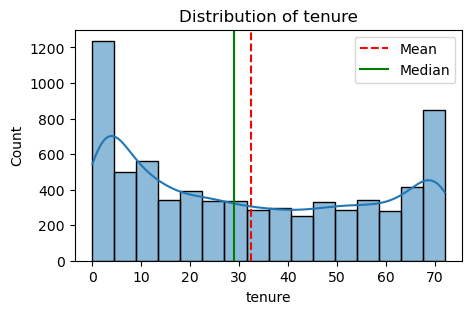

In [20]:
plot_histogram(churn_df,"tenure")

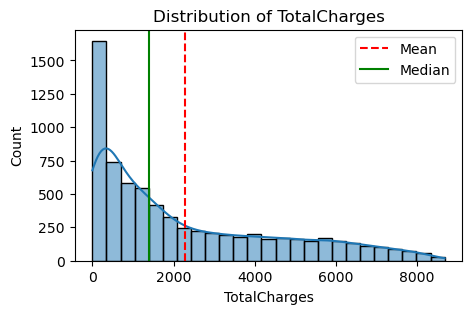

In [21]:
plot_histogram(churn_df,"TotalCharges")

In [22]:
def plot_boxplot(df,column_name):
    plt.figure(figsize=(5,3))
    sns.boxplot(y=df[column_name])
    plt.title(f"Distribution of {column_name}")
    plt.ylabel(column_name)
    plt.show

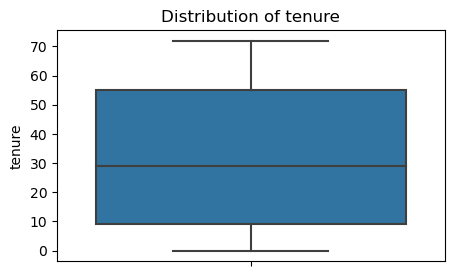

In [23]:
plot_boxplot(churn_df,"tenure")

Correlation Heatmap for numerical columns

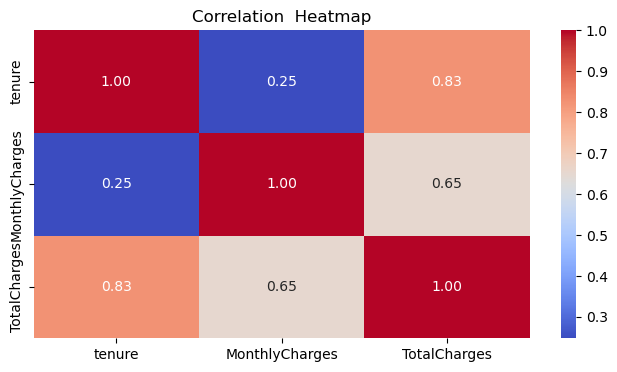

In [24]:
plt.figure(figsize=(8,4))
sns.heatmap(churn_df[["tenure","MonthlyCharges", "TotalCharges"]].corr(), annot=True, cmap="coolwarm" , fmt=".2f")
plt.title("Correlation  Heatmap")
plt.show()

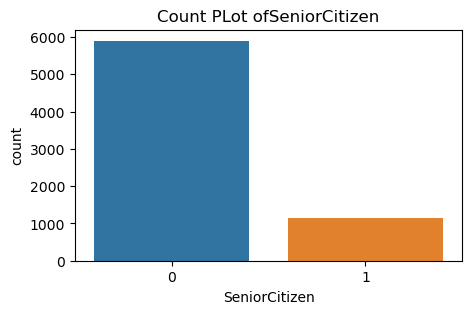

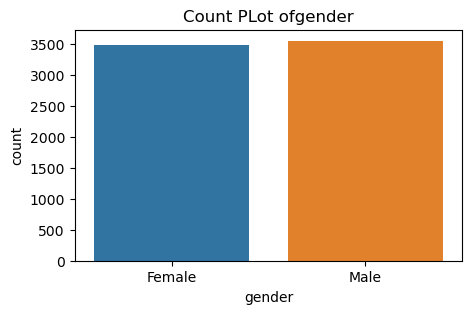

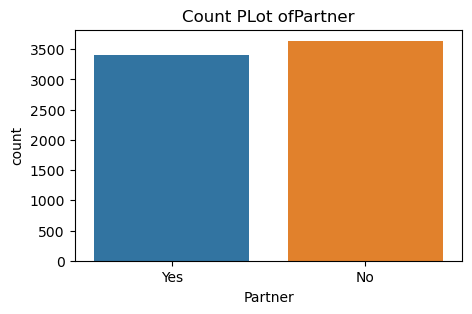

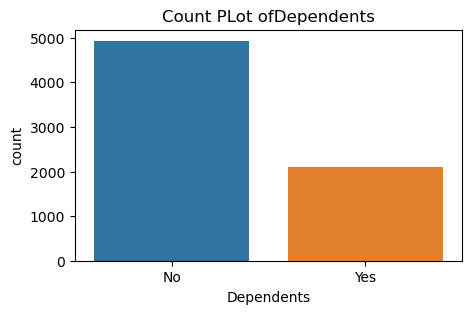

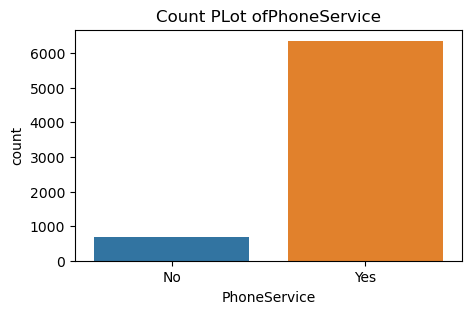

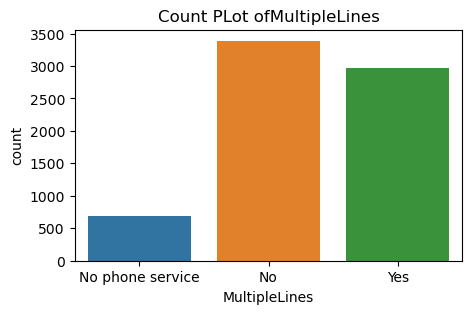

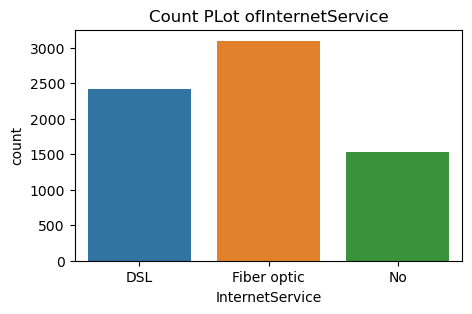

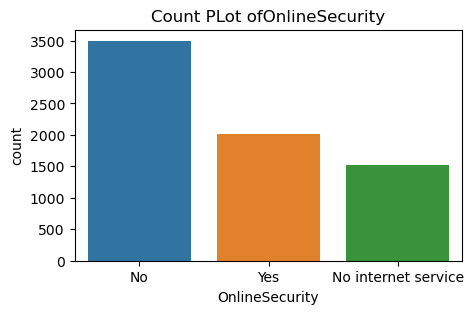

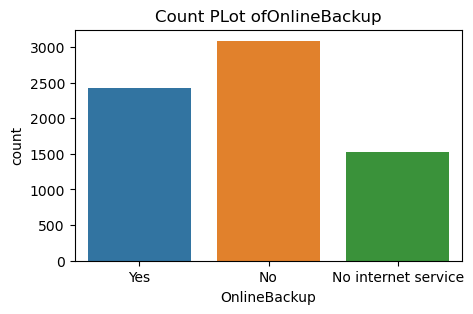

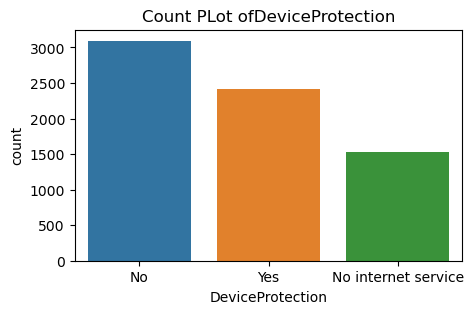

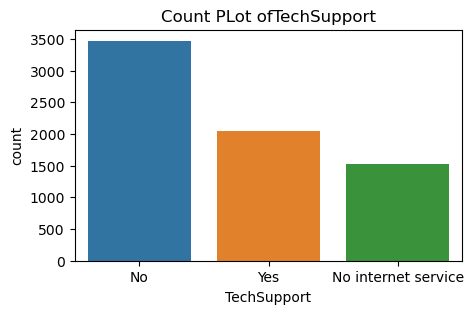

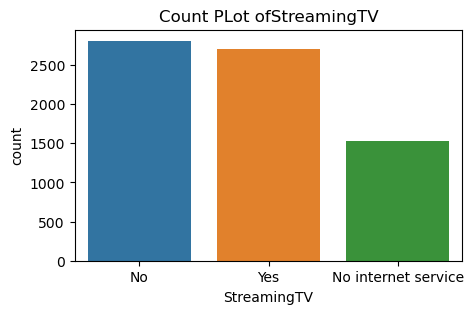

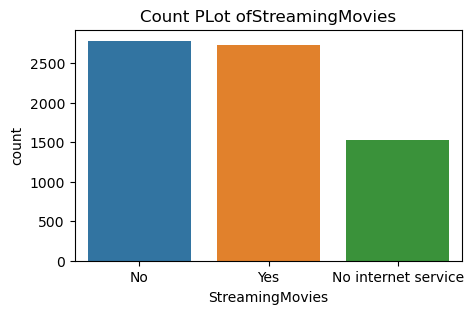

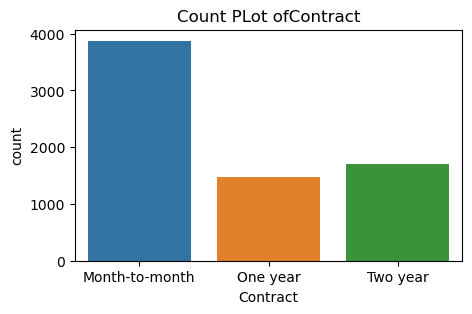

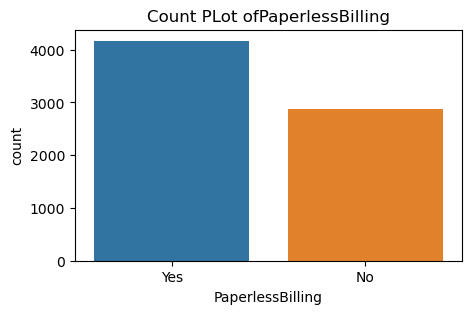

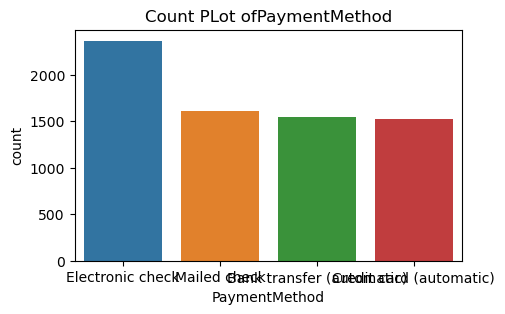

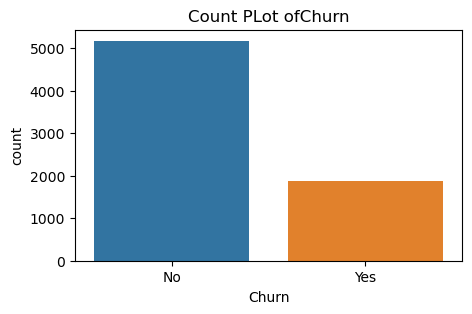

In [25]:
#countplot for categorical columns
object_cols=churn_df.select_dtypes(include="object").columns.to_list()
object_cols=["SeniorCitizen"]+object_cols

for col in object_cols:
    plt.figure(figsize=(5,3))
    sns.countplot(x=churn_df[col])
    plt.title(f"Count PLot of{col}")
    plt.show()

Label Encoding of target column

In [26]:
churn_df["Churn"]=churn_df["Churn"].replace({"Yes":1,"No":0})

In [27]:
#label encoding of categorical value
object_columns=churn_df.select_dtypes(include="object").columns


In [28]:
print(object_columns)

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')


In [29]:
import pickle
encoder={}

# apply label encoding and store the encoders
for column in object_columns:
    label_encoder=LabelEncoder()
    churn_df[column]=label_encoder.fit_transform(churn_df[column])
    encoder[column] =label_encoder
    
#save the encoders to a pickle file
with open("encoder.pkl","wb")as f:
    pickle.dump(encoder,f)
    

In [30]:
churn_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


In [31]:
#spltting the feature and target
x=churn_df.drop(columns=["Churn"])
y=churn_df["Churn"]

In [32]:
X_train,X_test,Y_train,Y_test =train_test_split(x,y ,test_size=0.2, random_state=42)

In [33]:
print(Y_train.shape)
print(Y_train.value_counts())

(5634,)
0    4138
1    1496
Name: Churn, dtype: int64


In [34]:
smote=SMOTE(random_state=42)

In [35]:
X_train_smote,Y_train_smote=smote.fit_resample(X_train,Y_train)

C:\Users\shrey\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\shrey\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 199, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\shrey\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\shrey\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\shrey\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

In [36]:
print(Y_train_smote.shape)

(8276,)


5. Model Training 

In [43]:
#dictionary of models
models={
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
}

In [44]:
# dictionary to store the cross validation results
cv_scores = {}

# perform 5-fold cross validation for each model
for model_name, model in models.items():
  print(f"Training {model_name} with default parameters")
  scores = cross_val_score(model, X_train_smote, Y_train_smote, cv=5, scoring="accuracy")
  cv_scores[model_name] = scores
  print(f"{model_name} cross-validation accuracy: {np.mean(scores):.2f}")
  print("-"*70)

Training Decision Tree with default parameters
Decision Tree cross-validation accuracy: 0.78
----------------------------------------------------------------------
Training Random Forest with default parameters
Random Forest cross-validation accuracy: 0.84
----------------------------------------------------------------------


In [45]:
cv_scores

{'Decision Tree': array([0.68115942, 0.71903323, 0.81752266, 0.84350453, 0.84350453]),
 'Random Forest': array([0.72705314, 0.76676737, 0.90453172, 0.89244713, 0.89848943])}

In [46]:
rfc = RandomForestClassifier(random_state=42)

In [48]:
rfc.fit(X_train_smote, Y_train_smote)

RandomForestClassifier(random_state=42)

In [50]:
print(Y_test.value_counts())

0    1036
1     373
Name: Churn, dtype: int64


In [52]:
# evaluate on test data
Y_test_pred = rfc.predict(X_test)

print("Accuracy Score:\n", accuracy_score(Y_test, Y_test_pred))
print("Confsuion Matrix:\n", confusion_matrix(Y_test, Y_test_pred))
print("Classification Report:\n", classification_report(Y_test, Y_test_pred))

Accuracy Score:
 0.7771469127040455
Confsuion Matrix:
 [[880 156]
 [158 215]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      1036
           1       0.58      0.58      0.58       373

    accuracy                           0.78      1409
   macro avg       0.71      0.71      0.71      1409
weighted avg       0.78      0.78      0.78      1409

